In [1]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Step 1: Retrieve ERA5 Data
file_path = "temperature_summer_equinox.nc"

if not os.path.exists(file_path):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': '2m_temperature',
            'year': '2024',
            'month': '09',
            'day': ['20','21','22','23','24'],
            'time': [
                '00:00', '01:00', '02:00', '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00', '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'
            ],
            'area': [90, -180, -90, 180],  # North, West, South, East
        },
        'temperature_summer_equinox.nc')

In [3]:
# Step 2: Load temperature data
data = xr.open_dataset('temperature_summer_equinox.nc')
temp_data = data['t2m'] - 273.15  # Convert from Kelvin to Celsius

temp_data = temp_data.rename({"valid_time":"time"})

c:\Users\Charlie\Documents\GitHub\mapping-challenge\.venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


1
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
0


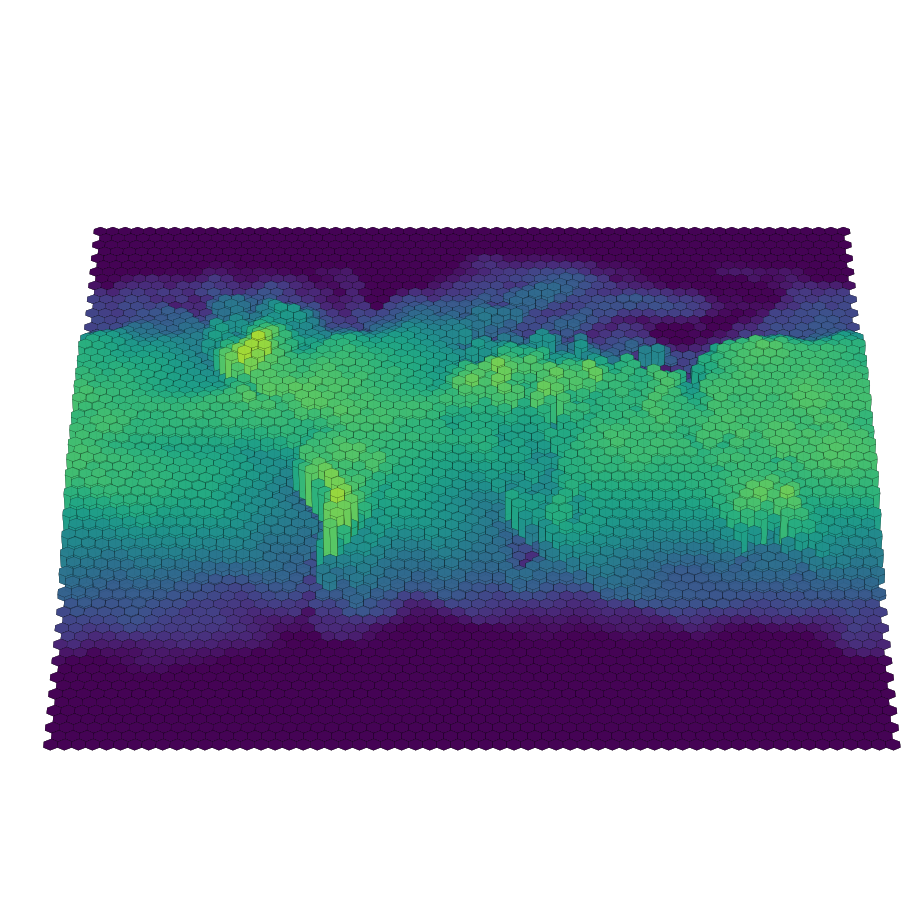

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import PillowWriter

# # Constants for the hexagonal grid
# num_rows = 20  # Number of rows of hexagons
# num_cols = 40  # Number of columns of hexagons
hourly_steps = 24*5  # Number of hourly steps for animation
hex_radius = 1.0  # Radius of each hexagon
min_temp = 10 # minimum temp to display
gridsize = 60

# Function to calculate vertices of a hexagon centered at (x_center, y_center)
def hexagon_vertices(x_center, y_center, radius, height=0):
    """Returns the vertices for a hexagon centered at (x_center, y_center) with a given radius."""
    angles = np.linspace(0, 2 * np.pi, 6, endpoint=False) + np.pi/6
    vertices = [(x_center + radius * np.cos(angle), y_center + radius * np.sin(angle), height) for angle in angles]
    return vertices

# Function to plot a hexagonal prism (3D hexagonal tower)
def plot_hex_prism(ax, x_center, y_center, height, hex_radius, color):
    """Draws a hexagonal prism at (x_center, y_center) with a given height and color."""
    # Get vertices for the top and bottom faces
    bottom_vertices = hexagon_vertices(x_center, y_center, hex_radius, height=min_temp)

    if height>min_temp:
        top_vertices = hexagon_vertices(x_center, y_center, hex_radius, height=height)
    else:
        top_vertices=bottom_vertices
    
    # Create top, bottom, and side faces of the hexagonal prism
    verts = [top_vertices, bottom_vertices]
    for i in range(6):
        verts.append([bottom_vertices[i], bottom_vertices[(i + 1) % 6],
                      top_vertices[(i + 1) % 6], top_vertices[i]])
    
    # Add the prism to the plot
    ax.add_collection3d(Poly3DCollection(verts, color=color, edgecolor='k', linewidth=0.1, alpha=0.9))

# Initialize the 3D figure
fig_tmp = plt.figure(figsize=(18, 9))
ax_tmp = fig_tmp.add_subplot(111)

fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
ax = fig.add_subplot(111, projection='3d')
ax.margins(x=0)
ax.margins(y=0)


# Updated animation function to plot hexagonal prisms instead of bars
def plot_hex_prisms(hour):
    print(hour)

    ax.cla()  # Clear previous frame

    # Set title for the current hour
    # ax.set_title(f"Temperature Map - Hour {hour}")

    # Set axis limits for visibility
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_zlim(min_temp, 40)

    # Set the view angle
    ax.view_init(elev=40, azim=-90)  # Change these values for different angles

    # Set equal scaling for x and y axes
    ax.set_aspect("equal", adjustable="box")

    #####
    temp_data_hour = temp_data.isel(time=hour)

    df = temp_data_hour.stack(points=("latitude", "longitude")).reset_index("points").to_dataframe(name="values").reset_index()

    x = df["longitude"]
    y = df["latitude"]
    values = df["values"]

    # print("here")
    plt.figure(fig_tmp.number)
    hb = plt.hexbin(x, y, C=values, gridsize=gridsize, cmap='viridis', reduce_C_function=np.mean)
    plt.close()
    # print("here")

    # Retrieve the x, y coordinates of the hexagon centers and the corresponding values
    x_centers = hb.get_offsets()[:, 0]
    y_centers = hb.get_offsets()[:, 1]*2
    hex_values = hb.get_array()

    # Stack into a single numpy array
    hex_data = np.column_stack((x_centers, y_centers, hex_values))

    #####

    # Plot each hexagon as a 3D prism
    for idx in range(len(x_centers)):
        x = x_centers[idx]
        y = y_centers[idx]
        height = hex_values[idx]
        color = plt.cm.viridis(height / 40)  # Color based on temperature scale

        # print("here 3")
        plt.figure(fig.number)
        plot_hex_prism(ax, x, y, height, hex_radius * 7 * 30/gridsize, color)
    # print("here 4")

    plt.axis("off")
    plt.grid(b=None)

plot_hex_prisms(1)

# Create a new animation with hexagonal prisms
ani_hex = FuncAnimation(fig, plot_hex_prisms, frames=hourly_steps, repeat=True)

# Save the updated animation as a gif
ani_hex.save('temperature_equinox.gif', writer=PillowWriter(fps=8))
